In [1]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import checkImageType, crossMask, ellipticalMask, mergeMasks, rectMask
from pepe.analysis import gSquared, adjacencyMatrix, weightedAdjacencyMatrix
from pepe.tracking import g2HoughCircle

import cv2
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

In [21]:
arr = np.array([[0, 0, 1], [0, 1, 0], [1, 1, 0]])

points = np.transpose(np.where(arr > 0))

print(points)

points = np.transpose(points)

print(points)

[[0 2]
 [1 1]
 [2 0]
 [2 1]]
[[0 1 2 2]
 [2 1 0 1]]


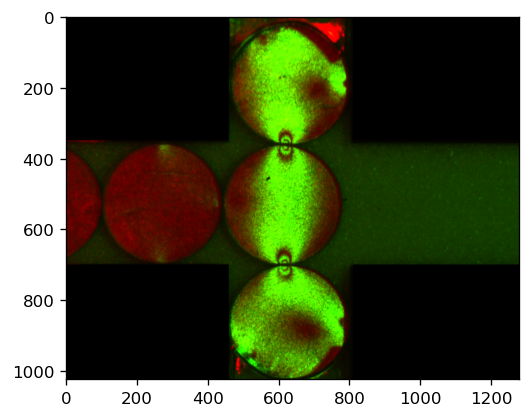

In [6]:
image = checkImageType('Data/Low_Saturation.bmp')
maskArr = crossMask(image.shape, xlim=[460, 810], ylim=[350, 700])

plt.imshow(image * maskArr)
plt.show()

imageArr = [checkImageType('Data/Low_Saturation.bmp'),
            checkImageType('Data/Mid_Saturation.bmp'),
            checkImageType('Data/High_Saturation.bmp'),
            checkImageType('Data/Very_High_Saturation.bmp')]

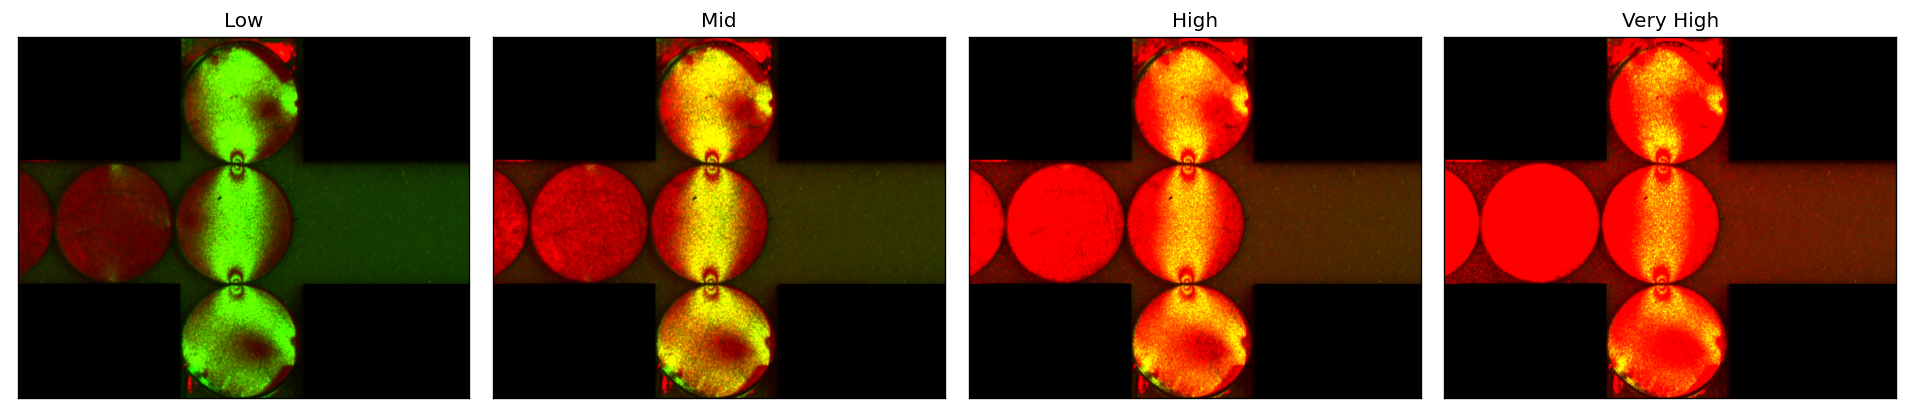

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    ax[i].imshow(imageArr[i] * maskArr)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[0].set_title('Low')
ax[1].set_title('Mid')
ax[2].set_title('High')
ax[3].set_title('Very High')

fig.tight_layout()
plt.savefig('saturation_comparison_raw.png')
plt.show()

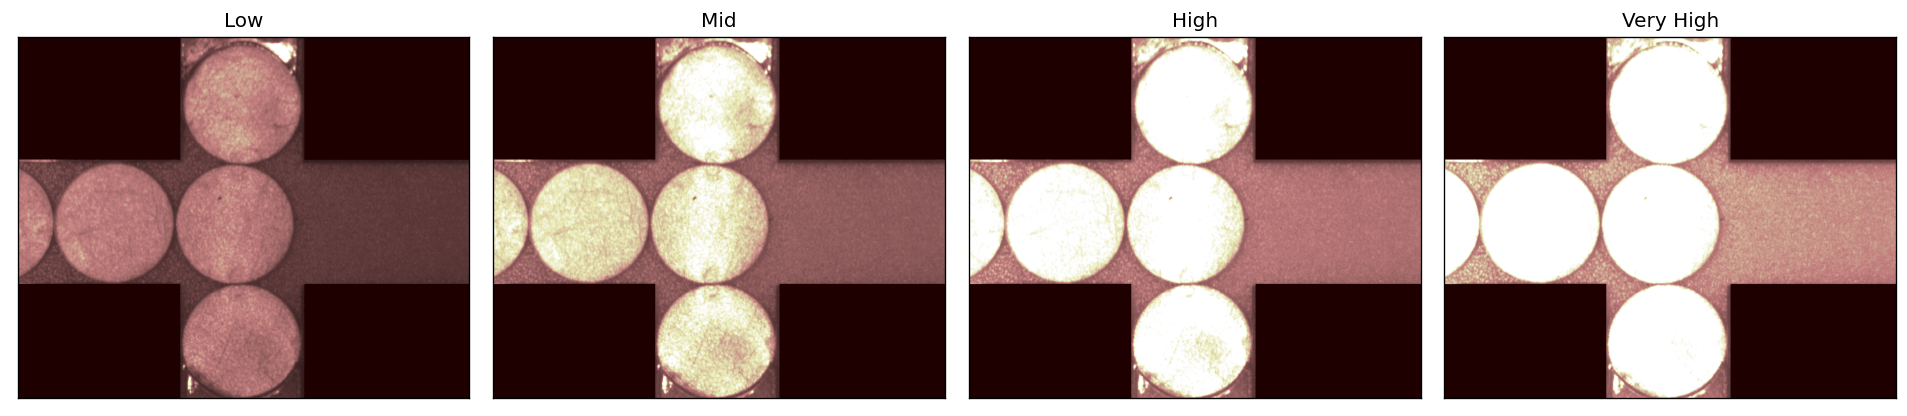

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    ax[i].imshow(imageArr[i][:,:,0] * maskArr[:,:,0], cmap=plt.get_cmap('pink'))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[0].set_title('Low')
ax[1].set_title('Mid')
ax[2].set_title('High')
ax[3].set_title('Very High')

fig.tight_layout()
plt.savefig('saturation_comparison_red.png')
plt.show()

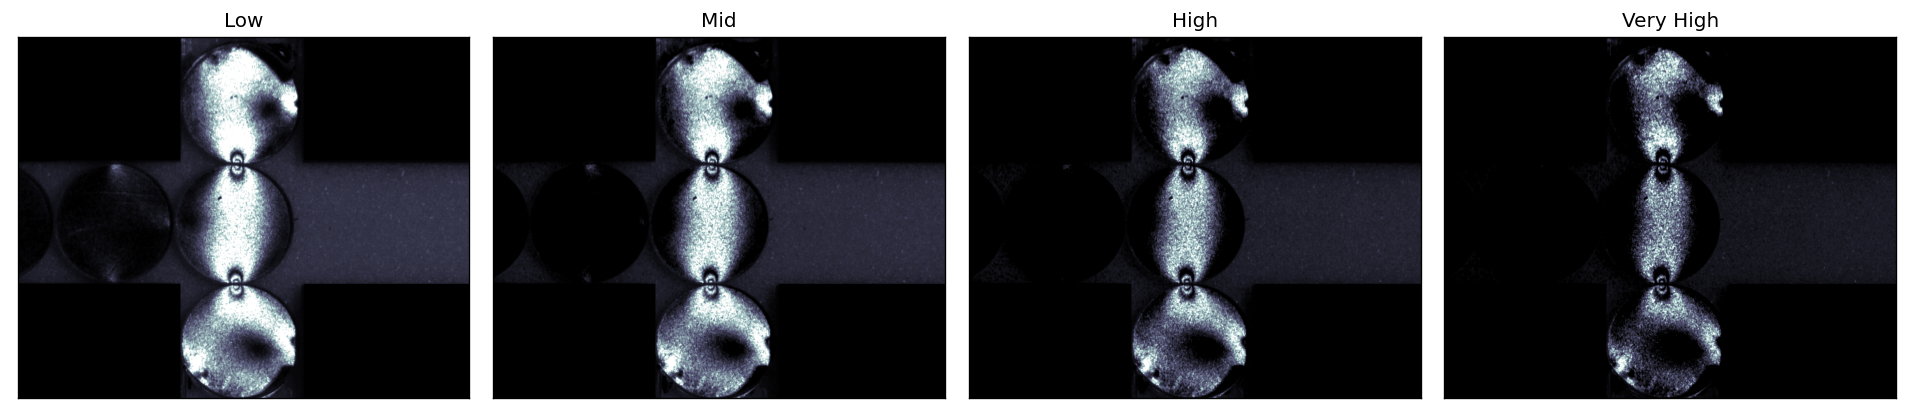

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    ax[i].imshow(imageArr[i][:,:,1] * maskArr[:,:,0], cmap=plt.get_cmap('bone'))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[0].set_title('Low')
ax[1].set_title('Mid')
ax[2].set_title('High')
ax[3].set_title('Very High')

fig.tight_layout()
plt.savefig('saturation_comparison_pe.png')
plt.show()

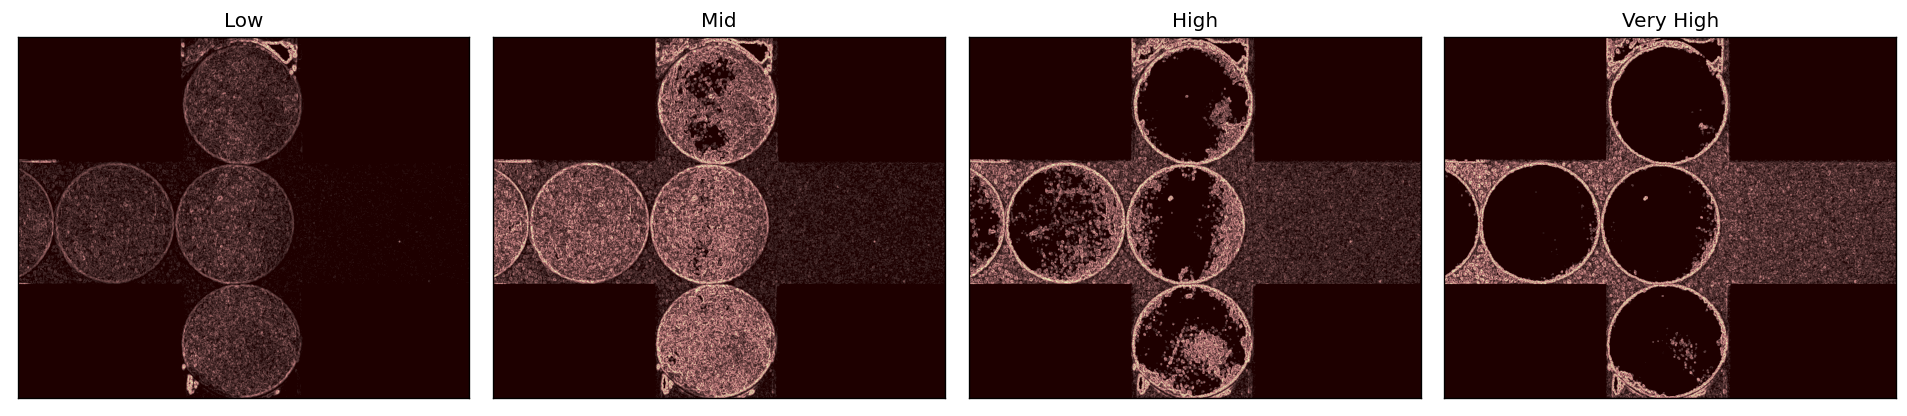

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    ax[i].imshow(gSquared(imageArr[i][:,:,0]) * maskArr[:,:,0], cmap=plt.get_cmap('pink'))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[0].set_title('Low')
ax[1].set_title('Mid')
ax[2].set_title('High')
ax[3].set_title('Very High')

fig.tight_layout()
plt.savefig('saturation_comparison_gsqr.png')
plt.show()

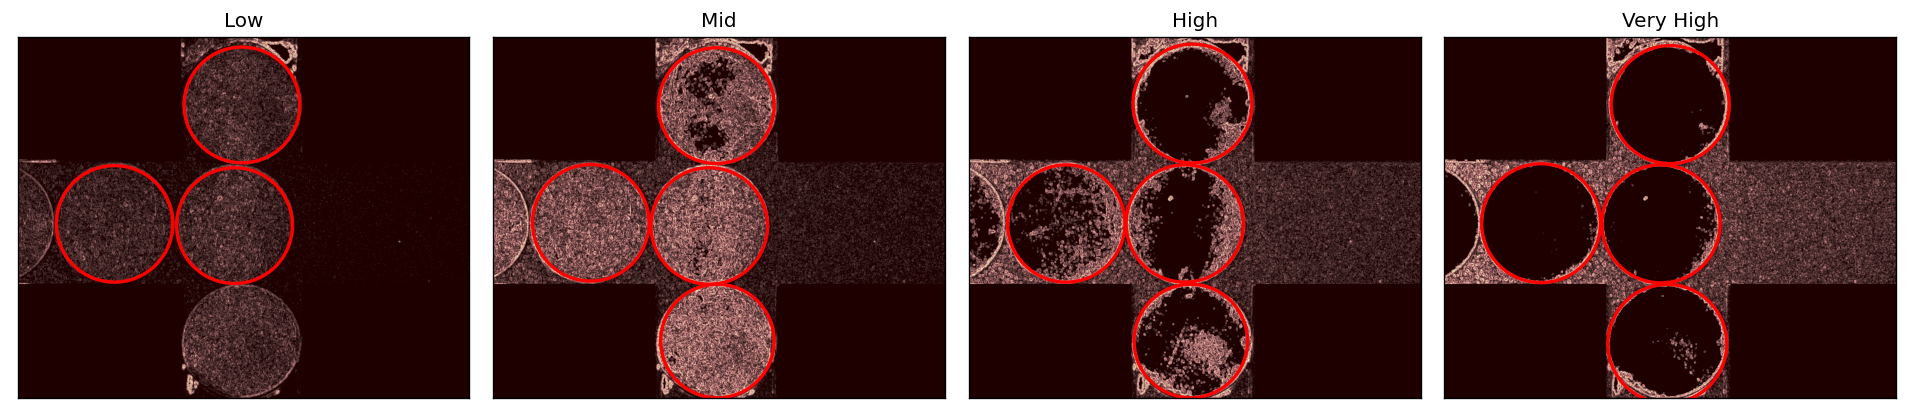

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    gSqr = gSquared(imageArr[i][:,:,0]) * maskArr[:,:,0]
    ax[i].imshow(gSqr, cmap=plt.get_cmap('pink'))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    detected_circles = cv2.HoughCircles(np.array(gSqr, dtype=np.uint8), 
                        cv2.HOUGH_GRADIENT,
                        dp=1, # Accumulator (no idea what it does, but 1 is good)
                        minDist=300, # Minimum distance between circles
                        param1=80, # Threshold for canny edge detection
                        param2=30, # Accumulator threshold
                        minRadius=160,
                        maxRadius=180)

    if detected_circles is not None:
        for pt in detected_circles[0, :]:
            c = plt.Circle((pt[0], pt[1]), pt[2], fill=False, color='red', linewidth=2)     
            ax[i].add_artist(c)
    
ax[0].set_title('Low')
ax[1].set_title('Mid')
ax[2].set_title('High')
ax[3].set_title('Very High')

fig.tight_layout()
plt.savefig('saturation_comparison_detection_4.png')
plt.show()

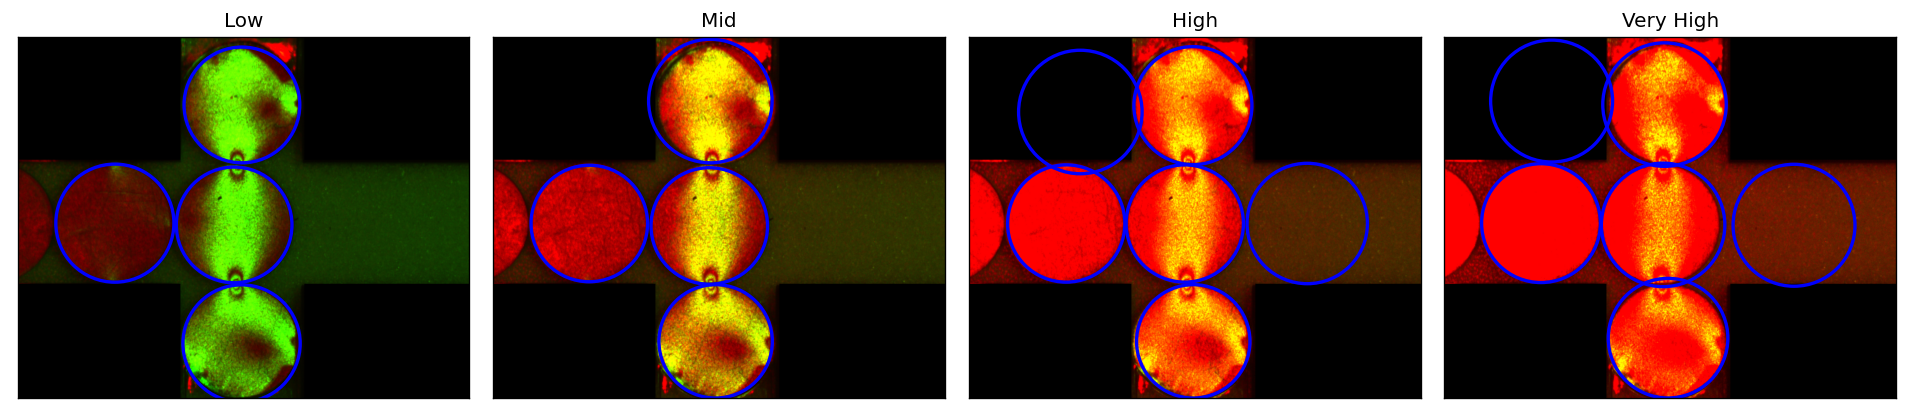

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    ax[i].imshow(imageArr[i] * maskArr)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    centers, radii = g2HoughCircle(imageArr[i][:,:,0], 170, radiusTolerance=10)
    
    if centers is not None:
        for j in range(len(centers)):
            c = plt.Circle((centers[j,1], centers[j,0]), radii[j], fill=False, color='blue', linewidth=2)     
            ax[i].add_artist(c)
    
ax[0].set_title('Low')
ax[1].set_title('Mid')
ax[2].set_title('High')
ax[3].set_title('Very High')

fig.tight_layout()
plt.savefig('saturation_comparison_detection_5.png')
plt.show()

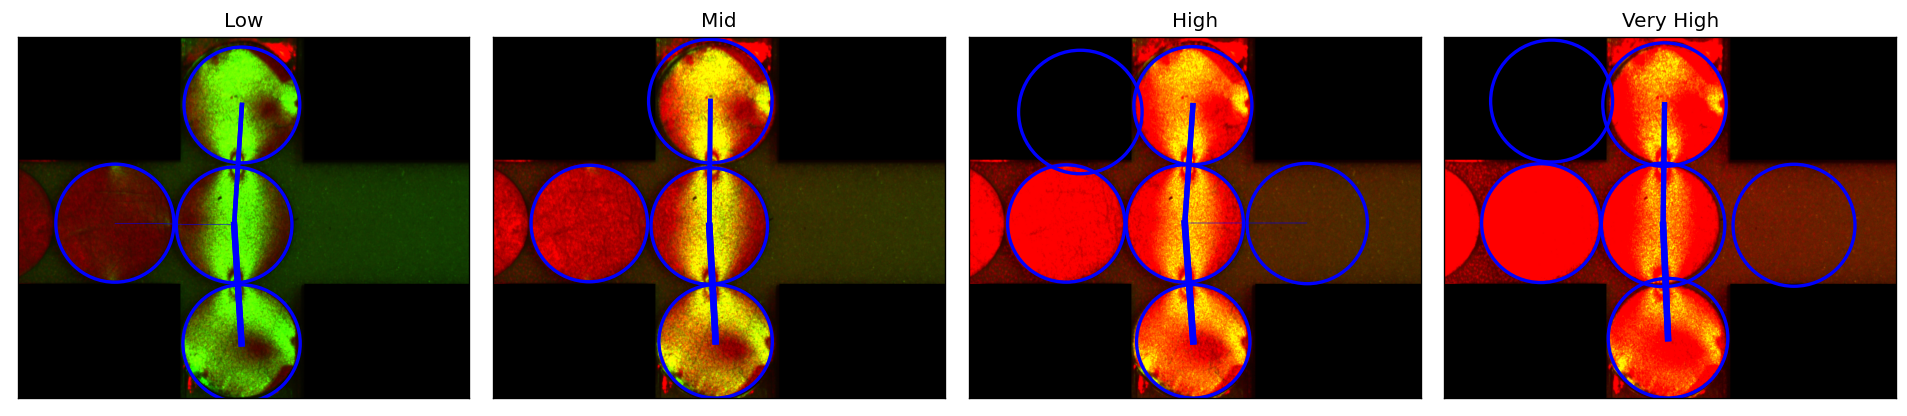

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    ax[i].imshow(imageArr[i] * maskArr)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    centers, radii = g2HoughCircle(imageArr[i][:,:,0], 170, radiusTolerance=10)
    
    if centers is not None:        
        for j in range(len(centers)):
            c = plt.Circle((centers[j,1], centers[j,0]), radii[j], fill=False, color='blue', linewidth=2)     
            ax[i].add_artist(c)
            
        adjMat = weightedAdjacencyMatrix(imageArr[i][:,:,1], centers, radii, contactPadding=20, contactThreshold=.01)
        for k in range(len(centers)):
            for j in range(len(centers)):
                if adjMat[k,j]:
                    ax[i].plot([centers[k,1], centers[j,1]], [centers[k,0], centers[j,0]], color='blue', linewidth=adjMat[k,j]*5)

    
ax[0].set_title('Low')
ax[1].set_title('Mid')
ax[2].set_title('High')
ax[3].set_title('Very High')

fig.tight_layout()
plt.savefig('saturation_comparison_detection_6.png')
plt.show()

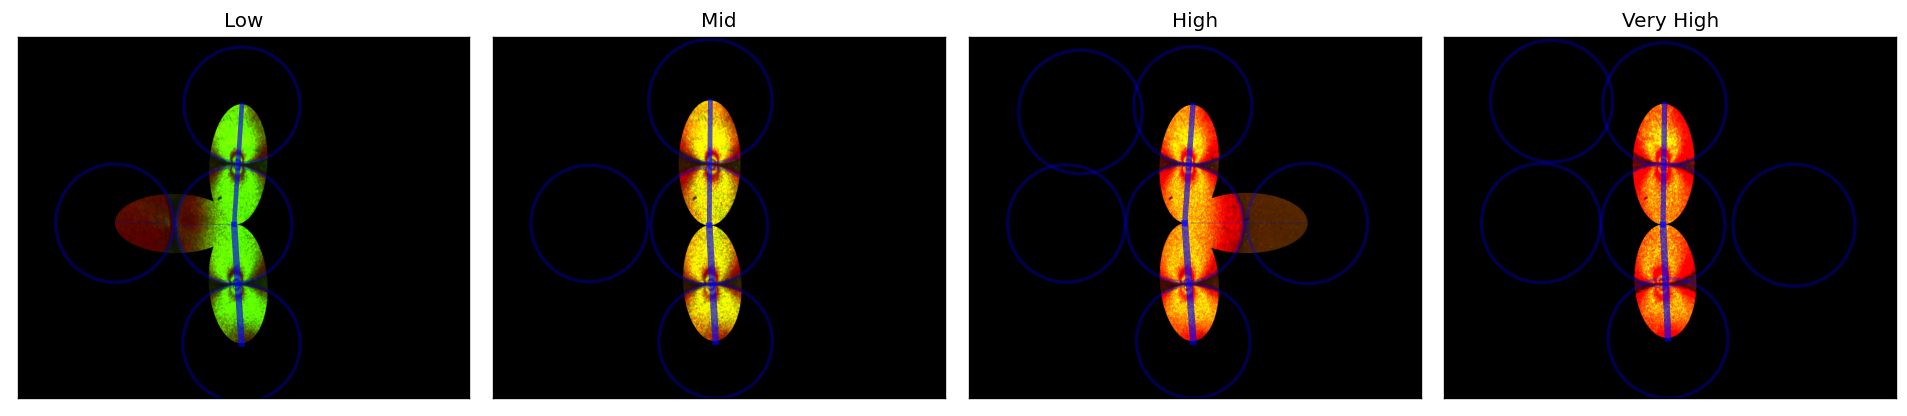

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    #ax[i].imshow(imageArr[i] * maskArr)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    centers, radii = g2HoughCircle(imageArr[i][:,:,0], 170, radiusTolerance=10)
    
    if centers is not None:        
        for j in range(len(centers)):
            c = plt.Circle((centers[j,1], centers[j,0]), radii[j], fill=False, color='blue', linewidth=2, alpha=.3)     
            ax[i].add_artist(c)
        
        currentMask = np.zeros_like(imageArr[i])
        
        adjMat = weightedAdjacencyMatrix(imageArr[i][:,:,1], centers, radii, contactPadding=20, contactThreshold=.01)
        for k in range(len(centers)):
            for j in range(len(centers)):
                if adjMat[k,j] and k != j:
                    ax[i].plot([centers[k,1], centers[j,1]], [centers[k,0], centers[j,0]], color='blue', linewidth=adjMat[k,j]*5, alpha=.4)
                    currentMask = mergeMasks([currentMask, ellipticalMask(imageArr[i].shape, [centers[k], centers[j]], radii[k])])

        #currentMask = currentMask + 1
        ax[i].imshow(imageArr[i] * currentMask)
        
ax[0].set_title('Low')
ax[1].set_title('Mid')
ax[2].set_title('High')
ax[3].set_title('Very High')

fig.tight_layout()
plt.savefig('saturation_comparison_detection_7.png')
plt.show()